# Susceptibility to substitution

## 1 Setup

Flags and settings.

In [1]:
SAVE_FIGURES = False
PAPER_FEATURES = ['frequency', 'aoa', 'clustering', 'letters_count',
                  'synonyms_count', 'orthographic_density']
BIN_COUNT = 4

Imports and database setup.

In [2]:
import pandas as pd
import seaborn as sb
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from progressbar import ProgressBar
from statsmodels.stats.proportion import multinomial_proportions_confint

%cd -q ..
from brainscopypaste.conf import settings
%cd -q notebooks
from brainscopypaste.mine import Model, Time, Source, Past, Durl
from brainscopypaste.db import Substitution
from brainscopypaste.utils import init_db, session_scope, stopwords
engine = init_db()

Build our data.

In [3]:
def qposition(values, position):
    value = values[position]
    if np.isnan(value):
        return np.nan, np.nan
    finite_values = values[np.isfinite(values)]
    svalues = np.array(sorted(finite_values))
    length = len(svalues)
    ours = np.where(svalues == value)[0]
    return ours[0] / length, (ours[-1] + 1) / length

In [4]:
model = Model(time=Time.continuous, source=Source.majority, past=Past.last_bin, durl=Durl.exclude_past, max_distance=2)
stop_poses = ['C', 'F', 'I', 'M', 'P', 'S', 'U']

data = []

# First get the exact substitution ids so we can get a working progress bar
# in the next step.
with session_scope() as session:
    substitutions = session.query(Substitution.id)\
        .filter(Substitution.model == model)
    print("Got {} substitutions for model {}"
          .format(substitutions.count(), model))
    substitution_ids = [id for (id,) in substitutions]

for substitution_id in ProgressBar(term_width=80)(substitution_ids):
    with session_scope() as session:
        substitution = session.query(Substitution).get(substitution_id)
        
        # Prepare these arrays for use in stopword-checking.
        dslice = slice(substitution.start,
                       substitution.start
                       + len(substitution.destination.tokens))
        lemmas = substitution.source.lemmas[dslice]
        tokens = substitution.source.tokens[dslice]
        tags = substitution.source.tags[dslice]
        is_stopword = np.array([(lemma in stopwords)
                                or (token in stopwords)
                                for (lemma, token) in zip(lemmas, tokens)])
        
        for feature in Substitution.__features__:
            
            # Get feature values for the sentence and its words.
            sentence_values, _ = substitution.\
                source_destination_features(feature)
            sentence_values_rel, _ = substitution.\
                source_destination_features(feature,
                                            sentence_relative='median')
            source_type, _ = Substitution.__features__[feature]
            words = getattr(substitution.source, source_type)[dslice]
            
            # Find the bins we'll use.
            # If there are only NaNs or only one feature value
            # we can't get bins on this sentence, so we want at least
            # 2 different feature values.
            # We also skip feature values if the source word is not coded
            # for the feature, as it would skew the 'appeared' 
            # distributions compared to the distribution of substituted
            # words. (For instance, the sum of categories would not be 
            # equal to the sum of H0s in the very last graphs, 
            # on sentencequantile. It also lets us make meaningful H0
            # comparison in all the other feature-based graphs.)
            non_sw_values = sentence_values.copy()
            non_sw_values[is_stopword] = np.nan
            non_sw_value_set = \
                set(non_sw_values[np.isfinite(non_sw_values)])
            if (len(non_sw_value_set) <= 1 or
                    np.isnan(sentence_values[substitution.position])):
                allnans = [np.nan] * len(non_sw_values)
                bins = allnans
                non_sw_values = allnans
                sentence_values = allnans
                sentence_values_rel = allnans
            else:
                bins = pd.cut(non_sw_values, BIN_COUNT, labels=False)
            
            # For each non-stopword, store its various properties.
            for i, (word, tag, skip) in enumerate(zip(words, tags,
                                                      is_stopword)):
                if skip:
                    # Drop any stopwords.
                    continue

                # Get a readable POS tag
                rtag = tag[0]
                rtag = 'Stopword-like' if rtag in stop_poses else rtag
                
                # Get the word's quantile position.
                start_quantile, stop_quantile = qposition(non_sw_values, i)

                # Store the word's properties.
                data.append({
                    'cluster_id': substitution.source.cluster.sid,
                    'destination_id': substitution.destination.sid,
                    'occurrence': substitution.occurrence,
                    'source_id': substitution.source.sid,
                    'position': substitution.position,
                    'feature': feature,
                    'word': word,
                    'POS': tag,
                    'rPOS': rtag,
                    'target': i == substitution.position,
                    'value': sentence_values[i],
                    'value_rel': sentence_values_rel[i],
                    'bin': bins[i],
                    'start_quantile': start_quantile,
                    'stop_quantile': stop_quantile,
                    'word_position': i
                })

words = pd.DataFrame(data)
del data

Got 1731 substitutions for model Model(time=Time.continuous, source=Source.majority, past=Past.last_bin, durl=Durl.exclude_past, max_distance=2)


  0% (   1 of 1731) |                      | Elapsed Time: 0:00:03 ETA:  1:45:18

  1% (  22 of 1731) |                      | Elapsed Time: 0:00:04 ETA:  0:00:27

  2% (  44 of 1731) |                      | Elapsed Time: 0:00:04 ETA:  0:00:27

  3% (  65 of 1731) |                      | Elapsed Time: 0:00:04 ETA:  0:00:30

  5% (  87 of 1731) |#                     | Elapsed Time: 0:00:05 ETA:  0:00:27

  6% ( 109 of 1731) |#                     | Elapsed Time: 0:00:05 ETA:  0:00:24

  7% ( 130 of 1731) |#                     | Elapsed Time: 0:00:05 ETA:  0:00:24

  8% ( 152 of 1731) |#                     | Elapsed Time: 0:00:06 ETA:  0:00:23

 10% ( 174 of 1731) |##                    | Elapsed Time: 0:00:06 ETA:  0:00:22

 11% ( 195 of 1731) |##                    | Elapsed Time: 0:00:06 ETA:  0:00:22

 12% ( 217 of 1731) |##                    | Elapsed Time: 0:00:07 ETA:  0:00:21

 13% ( 239 of 1731) |###                   | Elapsed Time: 0:00:07 ETA:  0:00:21

 15% ( 260 of 1731) |###                   | Elapsed Time: 0:00:08 ETA:  0:00:18

 16% ( 282 of 1731) |###                   | Elapsed Time: 0:00:08 ETA:  0:00:19

 17% ( 303 of 1731) |###                   | Elapsed Time: 0:00:08 ETA:  0:00:19

 18% ( 325 of 1731) |####                  | Elapsed Time: 0:00:09 ETA:  0:00:19

 20% ( 347 of 1731) |####                  | Elapsed Time: 0:00:09 ETA:  0:00:19

 21% ( 368 of 1731) |####                  | Elapsed Time: 0:00:09 ETA:  0:00:18

 22% ( 390 of 1731) |####                  | Elapsed Time: 0:00:10 ETA:  0:00:17

 23% ( 412 of 1731) |#####                 | Elapsed Time: 0:00:10 ETA:  0:00:17

 25% ( 433 of 1731) |#####                 | Elapsed Time: 0:00:10 ETA:  0:00:16

 26% ( 455 of 1731) |#####                 | Elapsed Time: 0:00:11 ETA:  0:00:17

 27% ( 477 of 1731) |######                | Elapsed Time: 0:00:11 ETA:  0:00:16

 28% ( 498 of 1731) |######                | Elapsed Time: 0:00:11 ETA:  0:00:16

 30% ( 520 of 1731) |######                | Elapsed Time: 0:00:12 ETA:  0:00:18

 31% ( 541 of 1731) |######                | Elapsed Time: 0:00:12 ETA:  0:00:17

 32% ( 563 of 1731) |#######               | Elapsed Time: 0:00:13 ETA:  0:00:17

 33% ( 585 of 1731) |#######               | Elapsed Time: 0:00:13 ETA:  0:00:17

 35% ( 606 of 1731) |#######               | Elapsed Time: 0:00:13 ETA:  0:00:16

 36% ( 628 of 1731) |#######               | Elapsed Time: 0:00:14 ETA:  0:00:16

 37% ( 650 of 1731) |########              | Elapsed Time: 0:00:14 ETA:  0:00:15

 38% ( 671 of 1731) |########              | Elapsed Time: 0:00:14 ETA:  0:00:14

 40% ( 693 of 1731) |########              | Elapsed Time: 0:00:15 ETA:  0:00:13

 41% ( 715 of 1731) |#########             | Elapsed Time: 0:00:15 ETA:  0:00:10

 42% ( 736 of 1731) |#########             | Elapsed Time: 0:00:15 ETA:  0:00:09

 43% ( 758 of 1731) |#########             | Elapsed Time: 0:00:16 ETA:  0:00:09

 45% ( 779 of 1731) |#########             | Elapsed Time: 0:00:16 ETA:  0:00:08

 46% ( 801 of 1731) |##########            | Elapsed Time: 0:00:16 ETA:  0:00:08

 47% ( 823 of 1731) |##########            | Elapsed Time: 0:00:17 ETA:  0:00:08

 48% ( 844 of 1731) |##########            | Elapsed Time: 0:00:17 ETA:  0:00:08

 50% ( 866 of 1731) |###########           | Elapsed Time: 0:00:17 ETA:  0:00:08

 51% ( 888 of 1731) |###########           | Elapsed Time: 0:00:18 ETA:  0:00:08

 52% ( 909 of 1731) |###########           | Elapsed Time: 0:00:18 ETA:  0:00:07

 53% ( 931 of 1731) |###########           | Elapsed Time: 0:00:18 ETA:  0:00:07

 55% ( 953 of 1731) |############          | Elapsed Time: 0:00:19 ETA:  0:00:07

 56% ( 974 of 1731) |############          | Elapsed Time: 0:00:19 ETA:  0:00:07

 57% ( 996 of 1731) |############          | Elapsed Time: 0:00:19 ETA:  0:00:07

 58% (1017 of 1731) |############          | Elapsed Time: 0:00:20 ETA:  0:00:07

 60% (1039 of 1731) |#############         | Elapsed Time: 0:00:20 ETA:  0:00:06

 61% (1061 of 1731) |#############         | Elapsed Time: 0:00:20 ETA:  0:00:06

 62% (1082 of 1731) |#############         | Elapsed Time: 0:00:21 ETA:  0:00:05

 63% (1104 of 1731) |##############        | Elapsed Time: 0:00:21 ETA:  0:00:05

 65% (1126 of 1731) |##############        | Elapsed Time: 0:00:21 ETA:  0:00:04

 66% (1147 of 1731) |##############        | Elapsed Time: 0:00:22 ETA:  0:00:04

 67% (1169 of 1731) |##############        | Elapsed Time: 0:00:22 ETA:  0:00:04

 68% (1191 of 1731) |###############       | Elapsed Time: 0:00:22 ETA:  0:00:04

 70% (1212 of 1731) |###############       | Elapsed Time: 0:00:23 ETA:  0:00:03

 71% (1234 of 1731) |###############       | Elapsed Time: 0:00:23 ETA:  0:00:03

 72% (1255 of 1731) |###############       | Elapsed Time: 0:00:23 ETA:  0:00:03

 73% (1277 of 1731) |################      | Elapsed Time: 0:00:24 ETA:  0:00:03

 75% (1299 of 1731) |################      | Elapsed Time: 0:00:25 ETA:  0:00:06

 76% (1320 of 1731) |################      | Elapsed Time: 0:00:25 ETA:  0:00:06

 77% (1342 of 1731) |#################     | Elapsed Time: 0:00:25 ETA:  0:00:05

 78% (1364 of 1731) |#################     | Elapsed Time: 0:00:26 ETA:  0:00:04

 80% (1385 of 1731) |#################     | Elapsed Time: 0:00:26 ETA:  0:00:04

 81% (1407 of 1731) |#################     | Elapsed Time: 0:00:26 ETA:  0:00:03

 82% (1429 of 1731) |##################    | Elapsed Time: 0:00:26 ETA:  0:00:02

 83% (1450 of 1731) |##################    | Elapsed Time: 0:00:27 ETA:  0:00:01

 85% (1472 of 1731) |##################    | Elapsed Time: 0:00:27 ETA:  0:00:01

 86% (1493 of 1731) |##################    | Elapsed Time: 0:00:27 ETA:  0:00:00

 87% (1515 of 1731) |###################   | Elapsed Time: 0:00:28 ETA:  0:00:00

 88% (1537 of 1731) |###################   | Elapsed Time: 0:00:28 ETA:  0:00:00

 90% (1558 of 1731) |###################   | Elapsed Time: 0:00:28 ETA:  0:00:00

 91% (1580 of 1731) |####################  | Elapsed Time: 0:00:29 ETA:  0:00:00

 92% (1602 of 1731) |####################  | Elapsed Time: 0:00:29 ETA:  0:00:00

 93% (1623 of 1731) |####################  | Elapsed Time: 0:00:29 ETA:  0:00:00

 95% (1645 of 1731) |####################  | Elapsed Time: 0:00:30 ETA:  0:00:00

 96% (1667 of 1731) |##################### | Elapsed Time: 0:00:30 ETA:  0:00:00

 97% (1688 of 1731) |##################### | Elapsed Time: 0:00:31 ETA:  0:00:00

 98% (1710 of 1731) |##################### | Elapsed Time: 0:00:31 ETA:  0:00:00

100% (1731 of 1731) |######################| Elapsed Time: 0:00:31 Time: 0:00:31


Assign proper weight to each substitution.

In [5]:
divide_target_all_sum = \
    lambda x: x / (words.loc[x.index].target 
                   * words.loc[x.index].weight_all).sum()
divide_target_feature_sum = \
    lambda x: x / (words.loc[x.index].target 
                   * words.loc[x.index].weight_feature).sum()

# Weight is 1, at first (or 1 for feature-coded substitutions).
words['weight_all'] = 1
words['weight_feature'] = 1 * np.isfinite(words.value)

# Divided by the number of substitutions that share a durl.
print('Computing shared durl (all) weights')
words['weight_all'] = words\
    .groupby(['destination_id', 'occurrence', 'position',
              'feature'])['weight_all']\
    .transform(divide_target_all_sum)
print('Computing shared durl (per-feature) weights')
words['weight_feature'] = words\
    .groupby(['destination_id', 'occurrence', 'position',
              'feature'])['weight_feature']\
    .transform(divide_target_feature_sum)

# Divided by the number of substitutions that share a cluster.
# (Using divide_target_sum, where we divide by the sum of weights,
# ensures we count only one for each group of substitutions sharing
# a same durl.)
print('Computing shared cluster (all) weights')
words['weight_all'] = words\
    .groupby(['cluster_id', 'feature'])['weight_all']\
    .transform(divide_target_all_sum)
print('Computing shared cluster (per-feature) weights')
words['weight_feature'] = words\
    .groupby(['cluster_id', 'feature'])['weight_feature']\
    .transform(divide_target_feature_sum)

# Add a weight measure for word appearances, weighing a word
# by the number of words that appear with it in its sentence.
# And the same for substitutions *whose source is coded by the feature*.
# (This lets us have the sum of categories equal the sum of H0s
# in the very last graphs [on sentencequantile], and make meaningful H0
# comparison values for all the other feature-based graphs.)
print('Computing appeared (all) weights')
words['weight_all_appeared'] = words\
    .groupby(['source_id', 'destination_id', 'occurrence',
              'position', 'feature'])['weight_all']\
    .transform(lambda x: x / len(x))
print('Computing appeared (per-feature) weights')
words['weight_feature_appeared'] = words\
    .groupby(['source_id', 'destination_id', 'occurrence',
              'position', 'feature'])['weight_feature']\
    .transform(lambda x: x / np.isfinite(words.loc[x.index].value).sum())

# In the above, note that when using a model that allows for multiple
# substitutions, those are stored as two separate substitutions in the
# database. This is ok, since we count the number of times a word is
# substituted compared to what it would have been substituted at
# random (i.e. we measure a bias, not a probability). Which leads us to
# count multiple substitutions in a same sentence as *different*
# substitutions, and to reflect this in the weights we must group
# substitutions by the position of the substituted word also (which is
# what we do here).

Computing shared durl (all) weights


Computing shared durl (per-feature) weights


Computing shared cluster (all) weights


Computing shared cluster (per-feature) weights


Computing appeared (all) weights


Computing appeared (per-feature) weights


Prepare feature ordering.

In [6]:
ordered_features = sorted(
    Substitution.__features__,
    key=lambda f: Substitution._transformed_feature(f).__doc__
)

Prepare counting functions.

In [7]:
target_all_counts = \
    lambda x: (x * words.loc[x.index, 'weight_all']).sum()
target_feature_counts = \
    lambda x: (x * words.loc[x.index, 'weight_feature']).sum()
appeared_all_counts = \
    lambda x: words.loc[x.index, 'weight_all_appeared'].sum()
appeared_feature_counts = \
    lambda x: words.loc[x.index, 'weight_feature_appeared'].sum()
susty_all = \
    lambda x: target_all_counts(x) / appeared_all_counts(x)
susty_feature = \
    lambda x: target_feature_counts(x) / appeared_feature_counts(x)

## 2 On POS

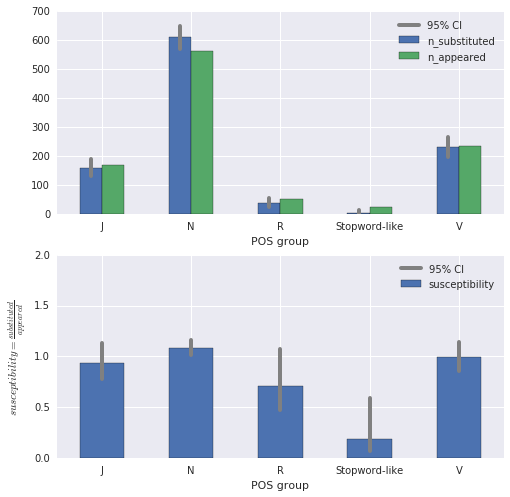

In [8]:
# Compute POS counts.
susties_pos = words[words.feature == 'aoa']\
    .groupby('rPOS')['target']\
    .aggregate({'susceptibility': susty_all,
                'n_substituted': target_all_counts,
                'n_appeared': appeared_all_counts})\
    .rename_axis('POS group')

# Plot.

fig, axes = plt.subplots(2, 1, figsize=(8, 8))
# Raw substituted and appeared values.
susties_pos[['n_substituted', 'n_appeared']]\
    .plot(ax=axes[0], kind='bar', rot=0)
# With their CIs.
total_substituted = susties_pos.n_substituted.sum()
cis = multinomial_proportions_confint(susties_pos.n_substituted.round(),
                                      method='goodman')
for i in range(len(susties_pos)):
    axes[0].plot([i-.125, i-.125], cis[i] * total_substituted,
                 lw=4, color='grey',
                 label='95% CI' if i == 0 else None)
axes[0].legend()
# Substitutability values.
susties_pos['susceptibility']\
    .plot(ax=axes[1], kind='bar', legend=True, ylim=(0, 2), rot=0)
axes[1].set_ylabel(r'$susceptibility = \frac{substituted}{appeared}$')
# With their CIs.
for i in range(len(susties_pos)):
    axes[1].plot([i, i], (cis[i] * total_substituted 
                          / susties_pos.n_appeared.iloc[i]),
                 lw=4, color='grey',
                 label='95% CI' if i == 0 else None)
axes[1].legend(loc='best')
# Save if necessary.
if SAVE_FIGURES:
    fig.savefig(settings.FIGURE.format('all-susceptibilities-pos'),
                bbox_inches='tight', dpi=300)

**Note on confidence intervals**

Here we're in case (3) of the explanation below on confidence intervals (in section 3): it's really like a multinomial sampling, but not quite since not all POS tags are available to sample from in all the sentences. There's no way out of this, so we're going to use multinomial CIs. We can safely scale all the bars and CIs to their respective `n_appeared` values, since that is an independent given before the sampling.

**Are the appeared and substituted proportions statistically different?**

The only test we can easily do is a multinomial goodness-of-fit. This tells us if the `n_substituted` counts are significantly different from the reference `n_appeared` counts.

From there on we know a few things:
* Comparing a given POS's `n_substituted` count to its reference `n_appeared` count tells us if it's statistically different (< or >). We know this will be true individually for any POS that is out of its confidence region for the global goodness-of-fit test, since it's a weaker hypothesis (so the null rejection region will be wider, and the POS we're looking at is already in the rejection region for the global test). We don't know if it'll be true or not for POSes that are in their confidence region for the global test.
* Jointly comparing two POS's `n_substituted` counts to their reference `n_appeared` counts tells us if there is bias for one w.r.t. the other. This is also true for all pairs of POSes that are on alternate sides of their confidence region in the global test (for the same reasons as in the previous point). We don't know if it's true for the other POSes though.

In [9]:
# Test the n_substituted proportions are different from
# the n_appeared proportions
total_appeared = susties_pos.n_appeared.sum()
appeared_cis = multinomial_proportions_confint(
    susties_pos.n_appeared.round(), method='goodman')
differences = [(s < ci[0] * total_appeared) or (s > ci[1] * total_appeared)
               for s, ci in zip(susties_pos.n_substituted, appeared_cis)]
are_different = np.any(differences)
if are_different:
    print("Appeared and substituted proportions are different with p < .05")
    print("The following POS tags are out of their confidence region:",
          list(susties_pos.index[np.where(differences)[0]]))
else:
    print("Appeared and substituted proportions cannot be "
          "said different with p value better than .05")

Appeared and substituted proportions are different with p < .05
The following POS tags are out of their confidence region: ['N', 'Stopword-like']


## 3 On global feature values

Prepare plotting functions, for bin and quartile susceptibilities for each feature.

In [10]:
def print_significance(feature, h0s, heights):
    h0_total = h0s.sum()
    bin_count = len(h0s)
    print()
    print('-' * len(feature))
    print(feature)
    print('-' * len(feature))
    for n_stars, alpha in enumerate([.05, .01, .001]):
        h0_cis = multinomial_proportions_confint(h0s.round(),
                                                 method='goodman',
                                                 alpha=alpha)
        differences = ((heights < h0_cis[:, 0] * h0_total)
                       | (heights > h0_cis[:, 1] * h0_total))
        are_different = np.any(differences)
        stars = ' ' * (3 - n_stars) + '*' * (1 + n_stars)
        if are_different:
            bins_different = np.where(differences)[0]
            bins_different += np.ones_like(bins_different)
            print(stars + ' Target different H_0 with p < {}.'
                  ' Bins [1; {}] out of region: {}'
                  .format(alpha, bin_count, bins_different.tolist()))
        else:
            print('     Target NOT different from H_0 (p > {})'
                  .format(alpha))
            break

In [11]:
def plot_bin_susties(**kwargs):
    data = kwargs['data']
    feature = data.iloc[0].feature
    color = kwargs.get('color', 'blue')
    relative = kwargs.get('relative', False)
    quantiles = kwargs.get('quantiles', False)
    value = data.value_rel if relative else data.value
    
    # Compute binning.
    cut, cut_kws = ((pd.qcut, {}) if quantiles
                    else (pd.cut, {'right': False}))
    for bin_count in range(BIN_COUNT, 0, -1):
        try:
            value_bins, bins = cut(value, bin_count, labels=False,
                                   retbins=True, **cut_kws)
            break
        except ValueError:
            pass
    middles = (bins[:-1] + bins[1:]) / 2

    # Compute bin counts. Note here the bins are computed on the
    # distribution of observed substitutions, not the simulated aggregated
    # distributions of cluster-unit substitutions. But since it's mostly
    # deduplication that the aggregation process addresses, the bins
    # should be mostly the same. This could be corrected by computing
    # bins on the aggregate distribution (not hard), but it's really
    # not important now.
    heights = np.zeros(bin_count)
    h0s = np.zeros(bin_count)
    for i in range(bin_count):
        heights[i] = (data[data.target & (value_bins == i)]
                      .weight_feature.sum())
        h0s[i] = data[value_bins == i].weight_feature_appeared.sum()
    total = sum(heights)
    cis = (multinomial_proportions_confint(heights.round(),
                                           method='goodman')
           * total / h0s[:, np.newaxis])
    
    # Plot them.
    sigmaphi = (r'\sigma_{\phi'
                + ('_r' if relative else '')
                + '}')
    plt.plot(middles, heights / h0s, 
             color=color, label='${}$'.format(sigmaphi))
    plt.fill_between(middles, cis[:, 0], cis[:, 1],
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.plot(middles, np.ones_like(middles), '--',
             color=sb.desaturate(color, 0.2),
             label='${}^0$'.format(sigmaphi))
    plt.xlim(middles[0], middles[-1])
    plt.ylim(0, 2)
    
    # Test for statistical significance
    print_significance(feature, h0s, heights)

In [12]:
def plot_grid(data, features, filename,
              plot_function, xlabel, ylabel, plot_kws={}):
    g = sb.FacetGrid(data=data[data['feature']
                               .map(lambda f: f in features)],
                     sharex=False, sharey=True,
                     col='feature', hue='feature',
                     col_order=features, hue_order=features,
                     col_wrap=3, aspect=1.5, size=3)
    g.map_dataframe(plot_function, **plot_kws)
    g.set_titles('{col_name}')
    g.set_xlabels(xlabel)
    g.set_ylabels(ylabel)
    for ax in g.axes.ravel():
        legend = ax.legend(frameon=True, loc='best')
        if not legend:
            # Skip if nothing was plotted on these axes.
            continue
        frame = legend.get_frame()
        frame.set_facecolor('#f2f2f2')
        frame.set_edgecolor('#000000')
        ax.set_title(Substitution._transformed_feature(ax.get_title())
                     .__doc__)
    if SAVE_FIGURES:
        g.fig.savefig(settings.FIGURE.format(filename),
                      bbox_inches='tight', dpi=300)

### 3.1 Bins of distribution of appeared global feature values


-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2]

--------------
phonemes_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1]

---------------
syllables_count
---------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2]
     Target NOT different from H_0 (p > 0.001)

---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out o


-----------
betweenness
-----------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [4]
     Target NOT different from H_0 (p > 0.01)

----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)

------
degree
------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [3]
     Target NOT different from H_0 (p > 0.001)

---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [2, 4]

--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1]
     Target NOT different from H_0 (p > 0.001)



--------
pagerank
--------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1]

--------------------
phonological_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]


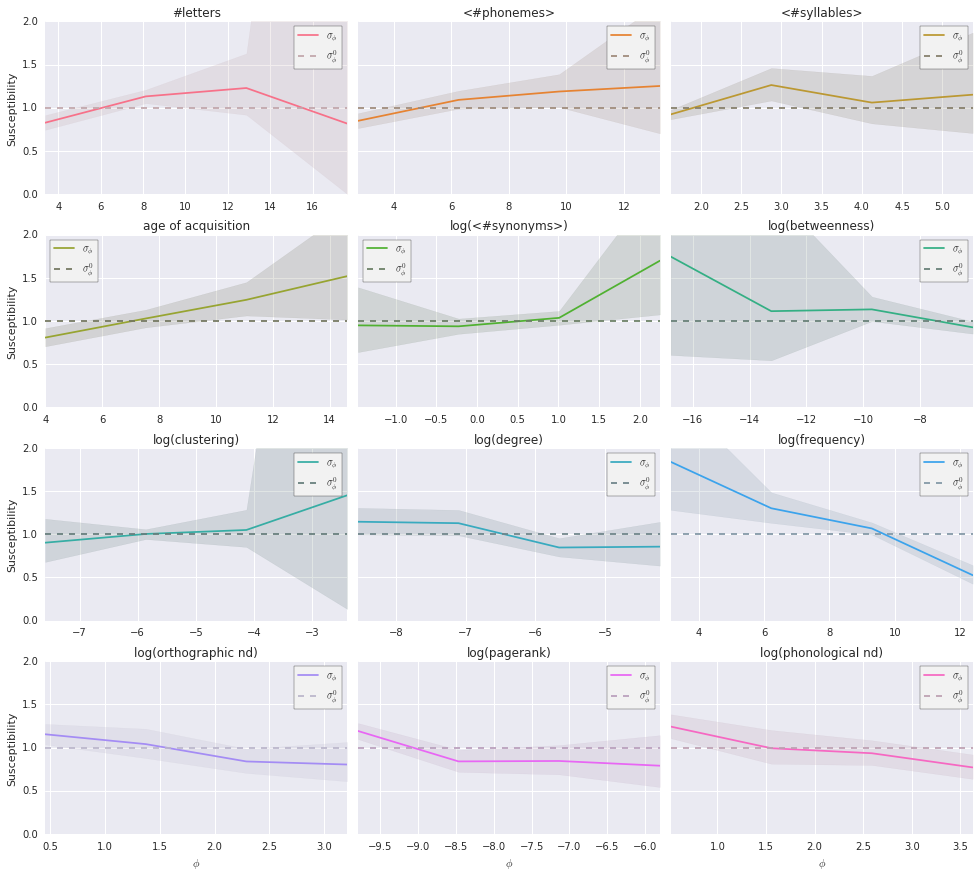

In [13]:
plot_grid(words, ordered_features,
          'all-susceptibilities-fixedbins_global',
          plot_bin_susties, r'$\phi$', 'Susceptibility')

**Note on how graphs and their confidence intervals are computed here**

There are three ways I can do a computation like above:

(1) For each word, we look at how many times it is substituted versus how many times it appears in a position where it could have been substituted. This is the *word*'s susceptibility, $\sigma(w)$. Then for each feature bin $b_i$ we take all the words such that $\phi(w) \in b_i$, average, and compute an asymptotic confidence interval based on how many words are in the bin. This fails for sentence-relative features, because a given word has different feature values depending on the sentence it appears in. So we discard this.

(2) Do the same but at the feature value level. So we define a *feature value* susceptibility, $\sigma_{\phi}(f)$, and compute a confidence interval based on how many different feature values we have in the bin. The idea behind (1) and (2) is to look at the bin middle-value like the relevant object we're measuring, and we have several measures for each bin middle-value, hence the confidence interval. In each bin $b_i$ we have:

$$\left< \sigma_{\phi}(f) \right>_{f \in b_i}$$

The problem with both (1) and (2) is that there's no proper $\mathcal{H}_0$ value, because the averages in the bins don't necessarily equal 1 under $\mathcal{H}_0$. Also, we can't check that there is consistency, showing that the sum of susceptibility values of the bins is 1. Hence case 3:

(3) Consider that we sample a multinomial process: each substitution is in fact the sampling of a feature value from one of the four bins. In that case, we can compute multinomial proportion CIs. This is also not completely satisfactory since in most cases not all feature values are available at the time of sampling, since most sentences don't range over all the feature's values, but it's what lets us compute proper null hypotheses: in each bin $b_i$ we have a value of $\sigma_{\phi}(b_i)$, and the sum of those should be the same under $\mathcal{H}_0$ as in the experiment (in practice in the graphs, we divide by the values under $\mathcal{H}_0$, and the reference is $\sigma_{\phi}^0(b_i) = 1$).

Here and below, we're always in case (3).


---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [2, 4]

---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1]

----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)

-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]

--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1]
     Target NOT different from H_0 (p > 0.001)


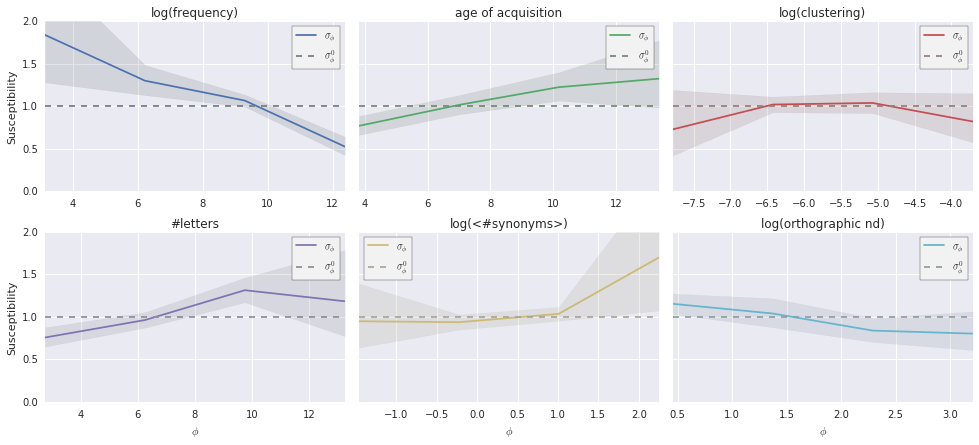

In [14]:
plot_grid(words[~(((words.feature == 'letters_count') 
                   & (words.value > 15))
                  | ((words.feature == 'aoa') 
                     & (words.value > 15))
                  | ((words.feature == 'clustering') 
                     & (words.value > -3)))],
          PAPER_FEATURES,
          'paper-susceptibilities-fixedbins_global',
          plot_bin_susties, r'$\phi$', 'Susceptibility')

### 3.2 Quantiles of distribution of appeared global feature values


-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]

--------------
phonemes_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1]

---------------
syllables_count
---------------
   * Target different H_0 with p < 0.05. Bins [1; 2] out of region: [1, 2]
  ** Target different H_0 with p < 0.01. Bins [1; 2] out of region: [1, 2]
 *** Target different H_0 with p < 0.001. Bins [1; 2] out of region: [1, 2]

---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different


-----------
betweenness
-----------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1]
     Target NOT different from H_0 (p > 0.01)

----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)

------
degree
------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [4]
     Target NOT different from H_0 (p > 0.01)

---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 4]



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [3]

--------
pagerank
--------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1]

--------------------
phonological_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]


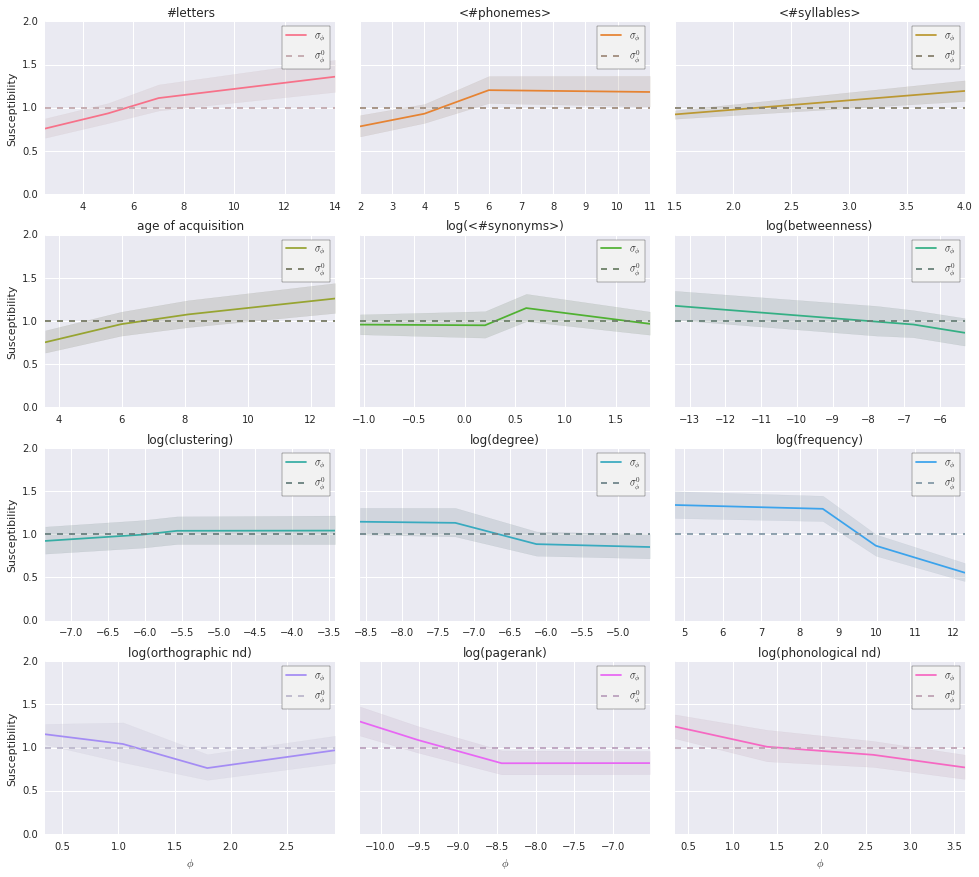

In [15]:
plot_grid(words, ordered_features,
          'all-susceptibilities-quantilebins_global', plot_bin_susties,
          r'$\phi$', 'Susceptibility',
          plot_kws={'quantiles': True})

**Note on confidence intervals**

Here we're again in case (2) of the above explanation on confidence intervals (in section 3.1), since we're just binning by quantiles instead of fixed-width bins.


---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 4]

---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]

----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)

-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]

--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [3]


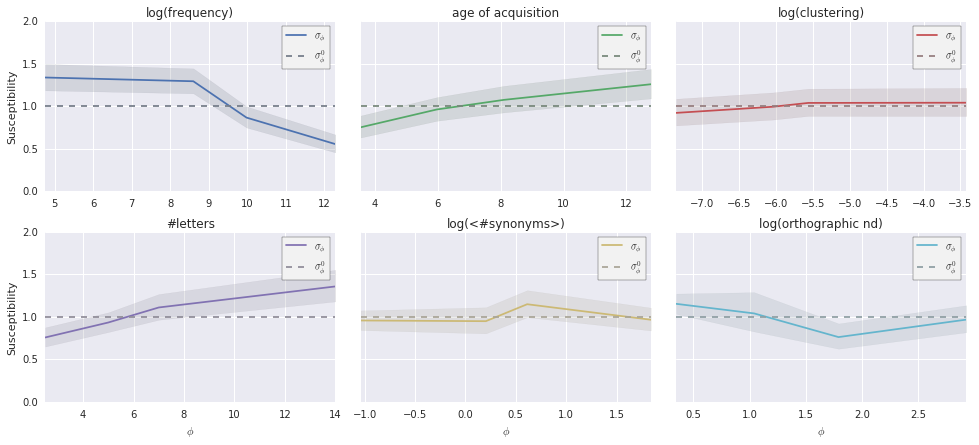

In [16]:
plot_grid(words, PAPER_FEATURES,
          'paper-susceptibilities-quantilebins_global', plot_bin_susties,
          r'$\phi$', 'Susceptibility',
          plot_kws={'quantiles': True})

## 4 On sentence-relative feature values

### 4.1 Bins of distribution of appeared sentence-relative values


-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]

--------------
phonemes_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]

---------------
syllables_count
---------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [2, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [2, 3]
     Target NOT different from H_0 (p > 0.001)

---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [2, 3, 4]
 *** Target different H_0 with p < 0.001. Bi


--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)

-----------
betweenness
-----------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [4]
     Target NOT different from H_0 (p > 0.01)

----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)

------
degree
------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
     Target NOT different from H_0 (p > 0.001)

---------
frequency
---------


   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [2, 3, 4]

--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
     Target NOT different from H_0 (p > 0.01)

--------
pagerank
--------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [3]
     Target NOT different from H_0 (p > 0.01)

--------------------
phonological_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1]


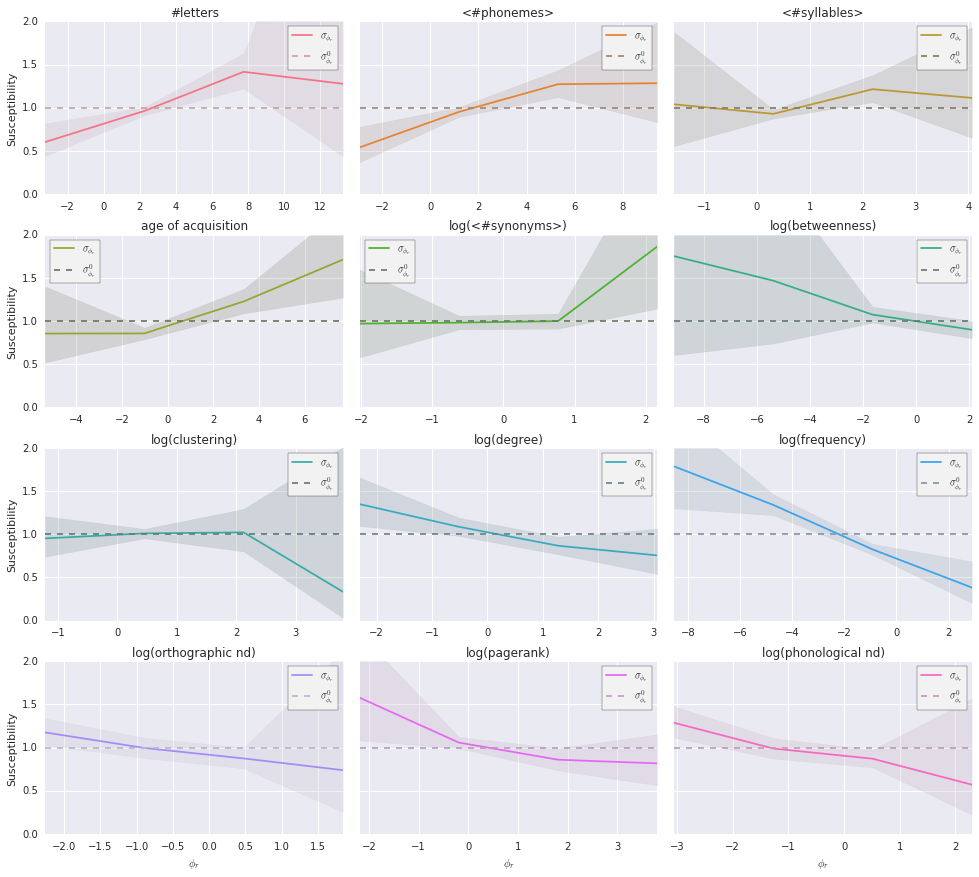

In [17]:
plot_grid(words, ordered_features,
          'all-susceptibilities-fixedbins_sentencerel',
          plot_bin_susties, r'$\phi_r$', 'Susceptibility',
          plot_kws={'relative': True})


---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [2, 3, 4]

---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [2, 3]

----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)

-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 3]

--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)

--------------------
orthographic_density

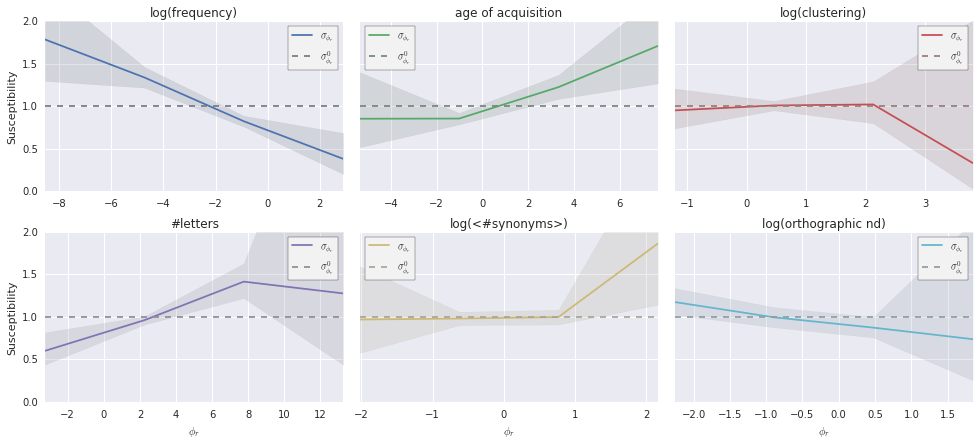

In [18]:
plot_grid(words, PAPER_FEATURES,
          'paper-susceptibilities-fixedbins_sentencerel',
          plot_bin_susties, r'$\phi_r$', 'Susceptibility',
          plot_kws={'relative': True})

### 4.2 Quantiles of distribution of appeared sentence-relative values


-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]

--------------
phonemes_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]

---------------
syllables_count
---------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1]

---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [2, 4]
 *** Target different


--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)

-----------
betweenness
-----------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1]
     Target NOT different from H_0 (p > 0.01)

----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)

------
degree
------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1]

---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]


  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]

--------------------
orthographic_density
--------------------
     Target NOT different from H_0 (p > 0.05)

--------
pagerank
--------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]

--------------------
phonological_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]


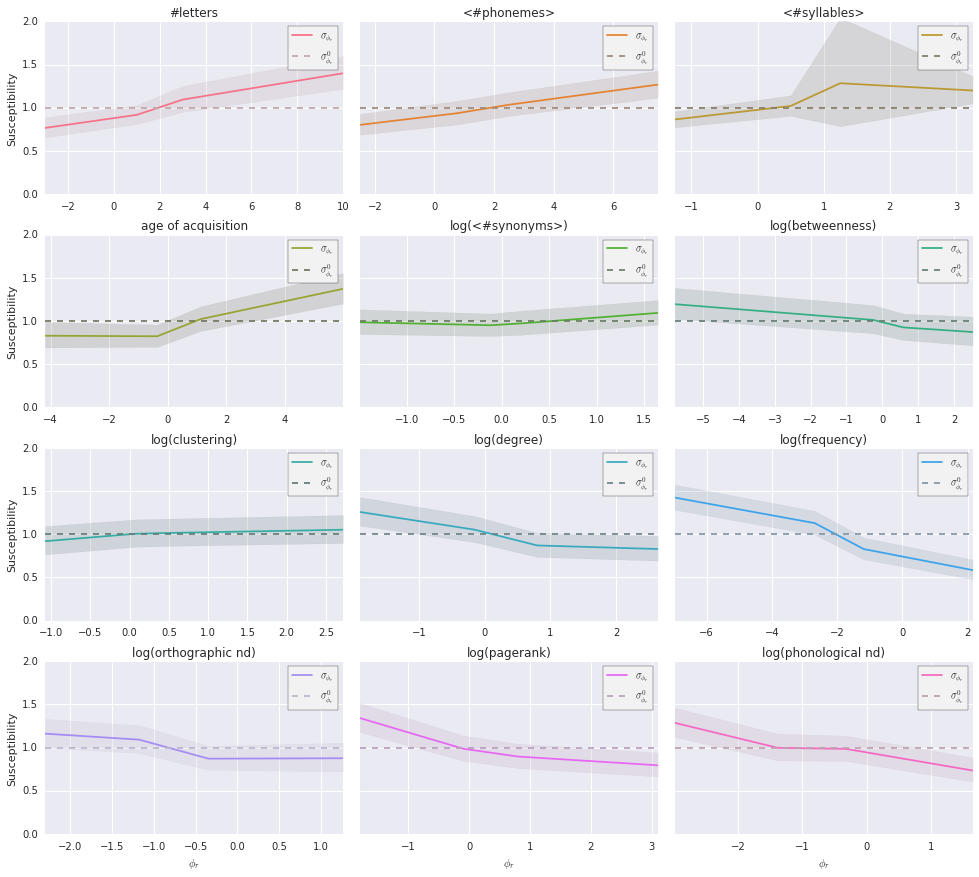

In [19]:
plot_grid(words, ordered_features,
          'all-susceptibilities-quantilebins_sentencerel',
          plot_bin_susties, r'$\phi_r$', 'Susceptibility',
          plot_kws={'quantiles': True, 'relative': True})


---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]

---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [4]

----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)

-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]

--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)



--------------------
orthographic_density
--------------------
     Target NOT different from H_0 (p > 0.05)


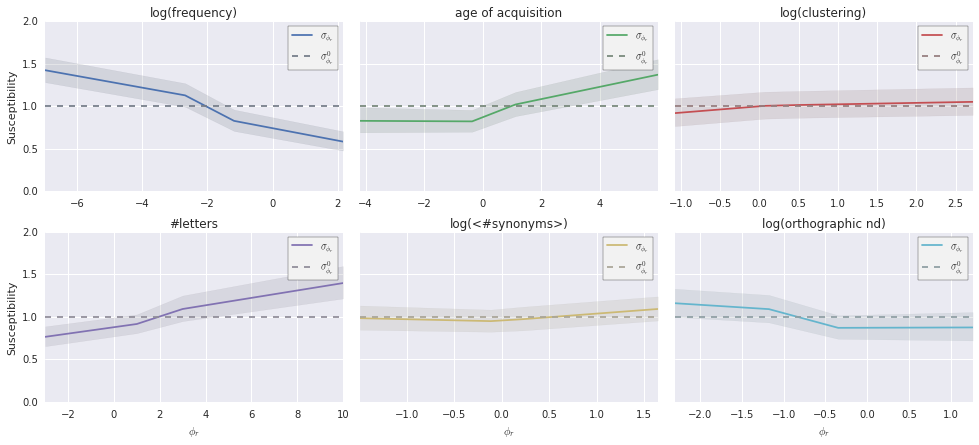

In [20]:
plot_grid(words, PAPER_FEATURES,
          'paper-susceptibilities-quantilebins_sentencerel',
          plot_bin_susties, r'$\phi_r$', 'Susceptibility',
          plot_kws={'quantiles': True, 'relative': True})

## 5 On quantiles and bins of the in-sentence distributions

### 5.1 In-sentence bins (of distribution of values in each sentence)

In [21]:
def plot_sentencebin_susties(**kwargs):
    data = kwargs['data']
    color = kwargs.get('color', 'blue')
    feature = data.iloc[0].feature
    
    # Compute bin counts
    heights = np.zeros(BIN_COUNT)
    h0s = np.zeros(BIN_COUNT)
    for i in range(BIN_COUNT):
        heights[i] = (data[data.target & (data.bin == i)]
                      .weight_feature.sum())
        h0s[i] = data[data.bin == i].weight_feature_appeared.sum()
    total = sum(heights)
    cis = (multinomial_proportions_confint(heights.round(),
                                           method='goodman')
           * total / h0s[:, np.newaxis])
    
    # Plot them.
    sigmaphi = r'\sigma_{bin_{\phi}}'
    x = range(1, BIN_COUNT + 1)
    plt.plot(x, heights / h0s, color=color, label='${}$'.format(sigmaphi))
    plt.fill_between(x, cis[:, 0], cis[:, 1],
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.plot(x, np.ones_like(x), '--',
             color=sb.desaturate(color, 0.2),
             label='${}^0$'.format(sigmaphi))
    plt.xticks(x)
    plt.ylim(0, None)
    
    # Test for significance.
    print_significance(feature, h0s, heights)


-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]

--------------
phonemes_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]

---------------
syllables_count
---------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1]

---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_


-----------
betweenness
-----------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
     Target NOT different from H_0 (p > 0.001)

----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)

------
degree
------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1]

---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]

--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p 


--------
pagerank
--------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]

--------------------
phonological_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]


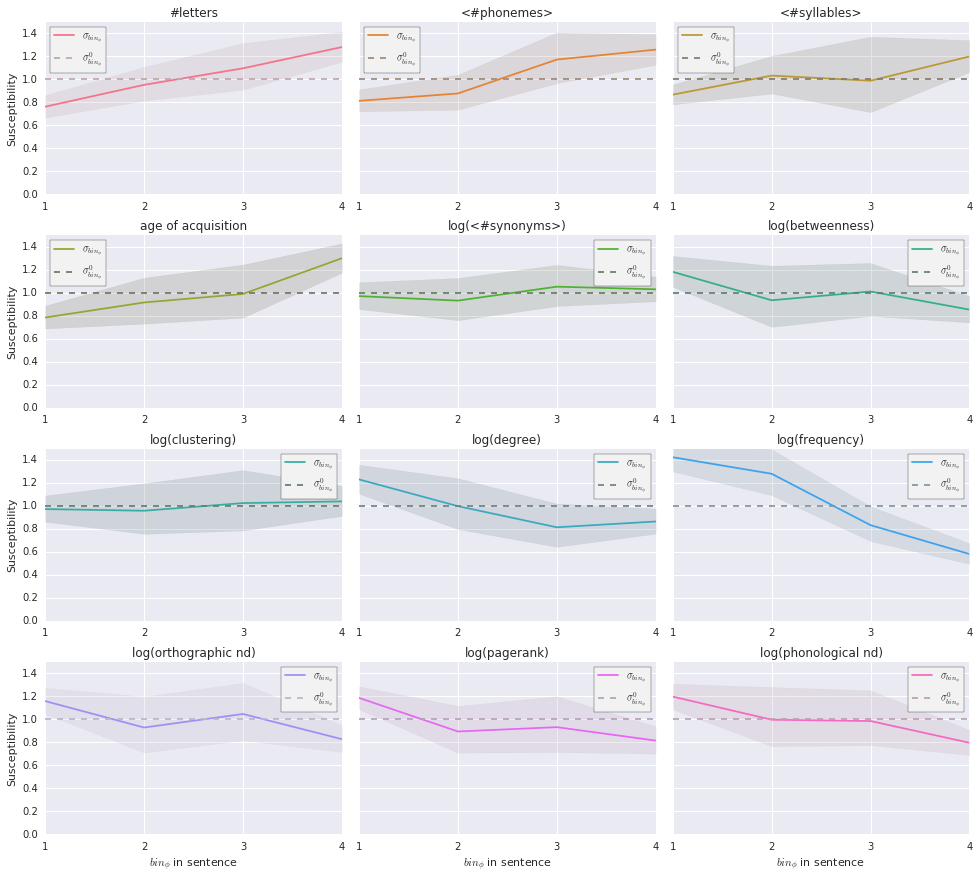

In [22]:
plot_grid(words, ordered_features,
          'all-susceptibilities-sentencebins',
          plot_sentencebin_susties, r'$bin_{\phi}$ in sentence',
          'Susceptibility')


---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]

---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]

----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)

-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]

--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)

--------------------
orthographic_density
-----------

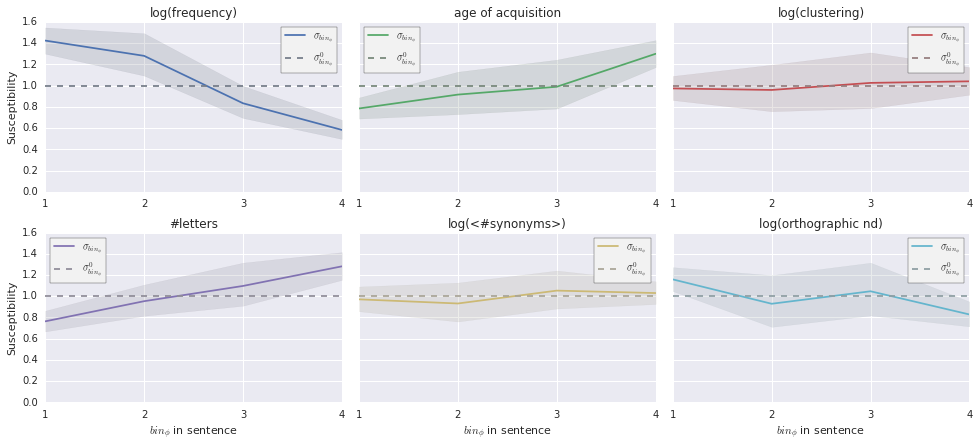

In [23]:
plot_grid(words, PAPER_FEATURES,
          'paper-susceptibilities-sentencebins',
          plot_sentencebin_susties, r'$bin_{\phi}$ in sentence',
          'Susceptibility')

### 5.2 In-sentence quantiles (of distribution of values in each sentence)

For each feature, count the sum of weights in each bin and plot that.

In [24]:
def bound(limits, values):
    left, right = limits
    assert left < right
    return np.maximum(left, np.minimum(right, values))

In [25]:
def plot_sentencequantile_susties(**kwargs):
    data = kwargs['data']
    color = kwargs.get('color', 'blue')
    feature = data.iloc[0].feature
    
    # Compute bin counts
    heights = np.zeros(BIN_COUNT)
    h0s = np.zeros(BIN_COUNT)
    step = 1 / BIN_COUNT
    for i in range(BIN_COUNT):
        limits = [i * step, (i + 1) * step]
        contributions = ((bound(limits, data.stop_quantile)
                          - bound(limits, data.start_quantile))
                         / (data.stop_quantile - data.start_quantile))
        heights[i] = \
            (contributions * data.weight_feature)[data.target].sum()
        h0s[i] = (contributions * data.weight_feature_appeared).sum()
    total = sum(heights)
    cis = (multinomial_proportions_confint(heights.round(),
                                           method='goodman')
           * total)# / h0s[:, np.newaxis])
    
    # Plot them.
    sigmaphi = r'\sigma_{q_{\phi}}'
    x = range(1, BIN_COUNT + 1)
    plt.plot(x, heights,# / h0s,
             color=color, label='${}$'.format(sigmaphi))
    plt.fill_between(x, cis[:, 0], cis[:, 1],
                     color=sb.desaturate(color, 0.2), alpha=0.2)
    plt.plot(x, h0s, '--',
             color=sb.desaturate(color, 0.2),
             label='${}^0$'.format(sigmaphi))
    plt.xticks(x)
    plt.ylim(0, None)
    
    # Test for significance.
    print_significance(feature, h0s, heights)


-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]

--------------
phonemes_count
--------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]

---------------
syllables_count
---------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [4]
     Target NOT different from H_0 (p > 0.001)

---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1;


-----------
betweenness
-----------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1]
     Target NOT different from H_0 (p > 0.001)

----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)

------
degree
------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1]

---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 3, 4]

--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
     Target NOT different from


--------
pagerank
--------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]

--------------------
phonological_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]


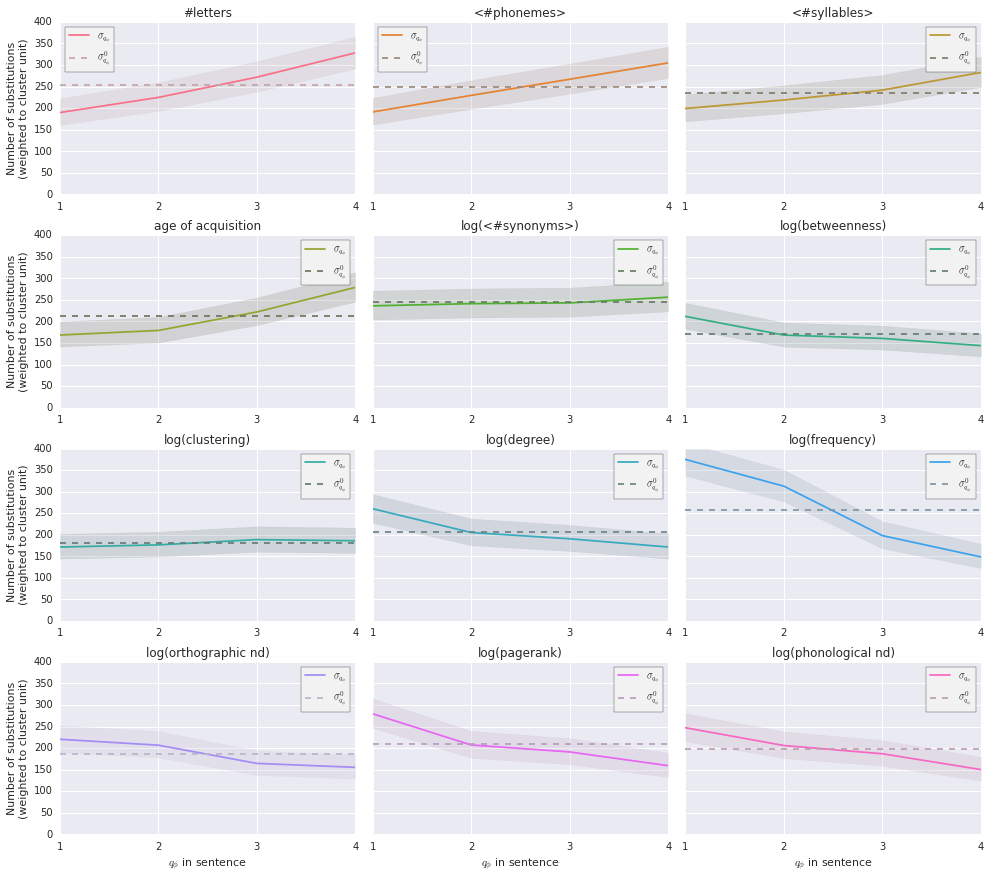

In [26]:
plot_grid(words, ordered_features,
          'all-susceptibilities-sentencequantiles',
          plot_sentencequantile_susties, r'$q_{\phi}$ in sentence',
          'Number of substitutions\n(weighted to cluster unit)')


---------
frequency
---------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 3, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 2, 3, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 2, 3, 4]

---
aoa
---
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 2, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]

----------
clustering
----------
     Target NOT different from H_0 (p > 0.05)

-------------
letters_count
-------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
  ** Target different H_0 with p < 0.01. Bins [1; 4] out of region: [1, 4]
 *** Target different H_0 with p < 0.001. Bins [1; 4] out of region: [1, 4]

--------------
synonyms_count
--------------
     Target NOT different from H_0 (p > 0.05)



--------------------
orthographic_density
--------------------
   * Target different H_0 with p < 0.05. Bins [1; 4] out of region: [1, 4]
     Target NOT different from H_0 (p > 0.01)


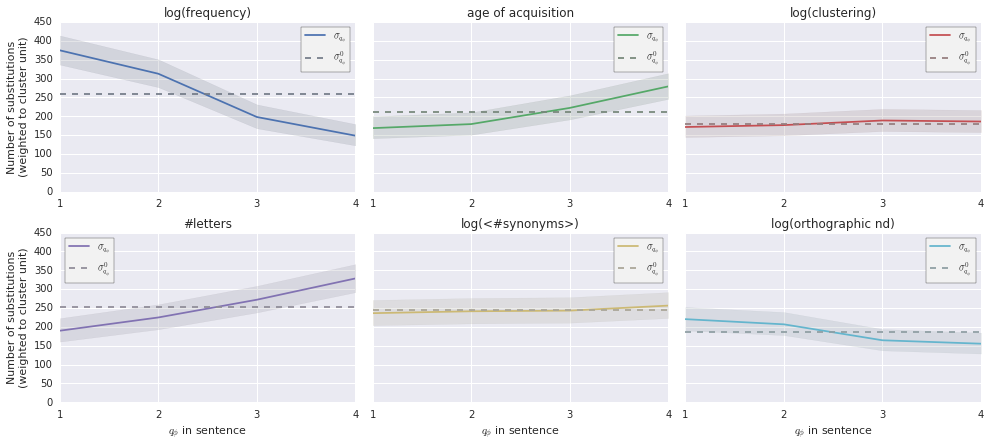

In [27]:
plot_grid(words, PAPER_FEATURES,
          'paper-susceptibilities-sentencequantiles',
          plot_sentencequantile_susties, r'$q_{\phi}$ in sentence',
          'Number of substitutions\n(weighted to cluster unit)')

## 6 Regression on significant features

### 6.1 Multinomial logistic regression

We try to predict which words are substituted, based on their global values, sentence-relative values, bins and quantiles of those, or in-sentence bin values.

Prediction is not good, mainly because the constraint of one-substitution-per-sentence can't be factored in the model simply. So precision is generally very low, around .20-.25, and when accuracy goes up recall plummets.

So it might show some interaction effects, but given that the fit is very bad I wouldn't trust it.

In-sentence quantiles (from section 5.2) were not done, as they're impossible to reduce to one value (our measure of those quantiles is in fact a subrange of [0, 1] for each word, corresponding to the subrange of the sentence distribution that that word's feature value represented).

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import binom_test

In [29]:
def regress_binning(data, features, value_funcs):
    # Compute bins
    data = data.copy()
    regress_features = [('{}'.format(value_name), feature)
                        for value_name in value_funcs.keys()
                        for feature in features]
    for i, (value_name, value_func) in enumerate(value_funcs.items()):
        data[value_name] = value_func(data)
    
    # Massage the dataframe to have feature bin as columns.
    data_wide = pd.pivot_table(
        data,
        values=list(value_funcs.keys()),
        index=['destination_id', 'occurrence', 'source_id', 'position',
               'word_position'],
        columns=['feature']
    )[regress_features]

    # Add the target value.
    # Question/FIXME: should we use weight_appeared for regression?
    data_wide['target'] = pd.pivot_table(
        data,
        values=['target'],
        index=['destination_id', 'occurrence', 'source_id', 'position',
               'word_position'],
        columns=['feature']
    )[('target', 'aoa')]
    data_wide = data_wide.dropna()

    # Compute polynomial features.
    poly = PolynomialFeatures(degree=2, interaction_only=True)
    pdata = poly.fit_transform(data_wide[regress_features])
    pregress_features = [' * '.join(['_'.join(regress_features[j])
                                   for j, p in enumerate(powers)
                                   if p > 0]) or 'intercept'
                         for powers in poly.powers_]

    # Divide into two sets.
    print('Regressing with {} word measures (divided into'
          ' training and prediction sets)'
          .format(len(data_wide)))
    pdata_train = pdata[:len(data_wide) // 2]
    target_train = data_wide.iloc[:len(data_wide) // 2].target
    pdata_predict = pdata[len(data_wide) // 2:]
    target_predict = data_wide.iloc[len(data_wide) // 2:].target
    assert len(pdata_train) + len(pdata_predict) == len(data_wide)
    assert len(target_train) + len(target_predict) == len(data_wide)
    
    # Regress
    regressor = LogisticRegression(penalty='l2', class_weight='balanced',
                                   fit_intercept=False)
    regressor.fit(pdata_train, target_train)
    
    # And predict
    prediction = regressor.predict(pdata_predict)
    standard = target_predict.values
    success = prediction == standard
    
    tp = prediction & standard
    tn = (~prediction) & (~standard)
    fp = prediction & (~standard)
    fn = (~prediction) & standard
    
    print()
    print('{:.2f}% of words well predicted (non-random at p = {:.1})'
          .format(100 * success.mean(),
                  binom_test(success.sum(), len(success))))
    print('Precision = {:.2f}'.format(standard[prediction].mean()))
    print('Recall = {:.2f}'.format(prediction[standard].mean()))
    print()
    print('Coefficients:')
    print(pd.Series(index=pregress_features, data=regressor.coef_[0]))

**Global feature value**

In [30]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'global': lambda d: d.value})

Regressing with 4928 word measures (divided into training and prediction sets)

54.95% of words well predicted (non-random at p = 1e-06)
Precision = 0.22
Recall = 0.56

Coefficients:
intercept                                             0.659712
global_frequency                                     -0.292400
global_aoa                                            0.079354
global_letters_count                                  0.272928
global_orthographic_density                          -0.592045
global_frequency * global_aoa                         0.018022
global_frequency * global_letters_count              -0.005865
global_frequency * global_orthographic_density        0.077953
global_aoa * global_letters_count                    -0.028099
global_aoa * global_orthographic_density              0.012481
global_letters_count * global_orthographic_density    0.001604
dtype: float64


**Sentence-relative feature value**

In [31]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'sentence-rel': lambda d: d.value_rel})

Regressing with 4928 word measures (divided into training and prediction sets)

59.29% of words well predicted (non-random at p = 3e-20)
Precision = 0.22
Recall = 0.49

Coefficients:
intercept                                                        -0.095814
sentence-rel_frequency                                           -0.061405
sentence-rel_aoa                                                  0.110786
sentence-rel_letters_count                                        0.050685
sentence-rel_orthographic_density                                 0.171720
sentence-rel_frequency * sentence-rel_aoa                         0.000804
sentence-rel_frequency * sentence-rel_letters_count              -0.013221
sentence-rel_frequency * sentence-rel_orthographic_density        0.068299
sentence-rel_aoa * sentence-rel_letters_count                     0.014793
sentence-rel_aoa * sentence-rel_orthographic_density              0.066024
sentence-rel_letters_count * sentence-rel_orthographic_density    0

**Global + sentence-relative feature values**

In [32]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'global': lambda d: d.value,
                 'sentence-rel': lambda d: d.value_rel})

Regressing with 4928 word measures (divided into training and prediction sets)

57.63% of words well predicted (non-random at p = 4e-14)
Precision = 0.23
Recall = 0.54

Coefficients:
intercept                                                         -0.280487
sentence-rel_frequency                                            -0.037166
sentence-rel_aoa                                                   0.579285
sentence-rel_letters_count                                         0.279698
sentence-rel_orthographic_density                                 -0.024590
global_frequency                                                  -0.100297
global_aoa                                                        -0.113474
global_letters_count                                               0.239020
global_orthographic_density                                       -0.387438
sentence-rel_frequency * sentence-rel_aoa                         -0.058585
sentence-rel_frequency * sentence-rel_letters_count      

**(3.1) Bins of distribution of appeared global feature values**

In [33]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'bins-global':
                     lambda d: pd.cut(d.value, BIN_COUNT,
                                      labels=False, right=False)})

Regressing with 4928 word measures (divided into training and prediction sets)

43.02% of words well predicted (non-random at p = 4e-12)
Precision = 0.21
Recall = 0.75

Coefficients:
intercept                                                       0.452831
bins-global_frequency                                           0.592671
bins-global_aoa                                                -0.662648
bins-global_letters_count                                       0.071897
bins-global_orthographic_density                                0.146603
bins-global_frequency * bins-global_aoa                        -0.045712
bins-global_frequency * bins-global_letters_count              -0.482187
bins-global_frequency * bins-global_orthographic_density       -0.030361
bins-global_aoa * bins-global_letters_count                     0.391532
bins-global_aoa * bins-global_orthographic_density              0.423770
bins-global_letters_count * bins-global_orthographic_density   -0.407445
dtype: float64

**(3.2) Quantiles of distribution of appeared global feature values**

In [34]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'quantiles-global':
                     lambda d: pd.qcut(d.value, BIN_COUNT, labels=False)})

Regressing with 4928 word measures (divided into training and prediction sets)

61.00% of words well predicted (non-random at p = 7e-28)
Precision = 0.23
Recall = 0.46

Coefficients:
intercept                                                                -0.045421
quantiles-global_frequency                                               -0.119306
quantiles-global_aoa                                                      0.178936
quantiles-global_letters_count                                            0.450912
quantiles-global_orthographic_density                                    -1.215680
quantiles-global_frequency * quantiles-global_aoa                        -0.336483
quantiles-global_frequency * quantiles-global_letters_count              -0.039728
quantiles-global_frequency * quantiles-global_orthographic_density        0.688532
quantiles-global_aoa * quantiles-global_letters_count                     0.252086
quantiles-global_aoa * quantiles-global_orthographic_density          

**(4.1) Bins of distribution of appeared sentence-relative values**

In [35]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'bins-sentence-rel':
                     lambda d: pd.cut(d.value_rel, BIN_COUNT,
                                      labels=False, right=False)})

Regressing with 4928 word measures (divided into training and prediction sets)

74.47% of words well predicted (non-random at p = 8e-136)
Precision = 0.27
Recall = 0.23

Coefficients:
intercept                                                                  -0.655427
bins-sentence-rel_frequency                                                 0.113361
bins-sentence-rel_aoa                                                       0.626093
bins-sentence-rel_letters_count                                             0.359080
bins-sentence-rel_orthographic_density                                     -0.655427
bins-sentence-rel_frequency * bins-sentence-rel_aoa                        -0.349551
bins-sentence-rel_frequency * bins-sentence-rel_letters_count              -0.215781
bins-sentence-rel_frequency * bins-sentence-rel_orthographic_density        0.113361
bins-sentence-rel_aoa * bins-sentence-rel_letters_count                    -0.451264
bins-sentence-rel_aoa * bins-sentence-rel_orthograp

**(4.2) Quantiles of distribution of appeared sentence-relative values**

In [36]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'quantiles-sentence-rel':
                     lambda d: pd.qcut(d.value_rel, BIN_COUNT,
                                       labels=False)})

Regressing with 4928 word measures (divided into training and prediction sets)

51.54% of words well predicted (non-random at p = 0.1)
Precision = 0.22
Recall = 0.62

Coefficients:
intercept                                                                             0.837865
quantiles-sentence-rel_frequency                                                     -0.344590
quantiles-sentence-rel_aoa                                                           -0.292488
quantiles-sentence-rel_letters_count                                                 -0.371670
quantiles-sentence-rel_orthographic_density                                          -0.587992
quantiles-sentence-rel_frequency * quantiles-sentence-rel_aoa                        -0.008728
quantiles-sentence-rel_frequency * quantiles-sentence-rel_letters_count              -0.013474
quantiles-sentence-rel_frequency * quantiles-sentence-rel_orthographic_density        0.174461
quantiles-sentence-rel_aoa * quantiles-sentence-rel_letters

**(5.1) In-sentence bins (of distribution of values in each sentence)**

In [37]:
regress_binning(words, ['frequency', 'aoa', 'letters_count',
                        'orthographic_density'],
                {'in-sentence-bins': lambda d: d.bin})

Regressing with 4928 word measures (divided into training and prediction sets)

63.92% of words well predicted (non-random at p = 7e-44)
Precision = 0.26
Recall = 0.51

Coefficients:
intercept                                                                 0.102610
in-sentence-bins_frequency                                               -0.270043
in-sentence-bins_aoa                                                      0.049016
in-sentence-bins_letters_count                                            0.016719
in-sentence-bins_orthographic_density                                    -0.035249
in-sentence-bins_frequency * in-sentence-bins_aoa                        -0.003483
in-sentence-bins_frequency * in-sentence-bins_letters_count              -0.088446
in-sentence-bins_frequency * in-sentence-bins_orthographic_density        0.068062
in-sentence-bins_aoa * in-sentence-bins_letters_count                     0.056393
in-sentence-bins_aoa * in-sentence-bins_orthographic_density          

### 6.2 PCA

We get coefficient values out of the PCA, but I can't figure what to make of them... They reflect the correlations of the features, alright, but beyond that? Some interactions, but there's no clear interpretation of the coefficients and variances explained into interaction strengths.

In [38]:
from sklearn.decomposition import PCA

In [39]:
def pca_values(data, features, value_func):
    data = data.copy()
    data['pca_value'] = value_func(data)
    
    # Prepare dataframe, averaging over shared durl.
    data_wide = pd.pivot_table(
        data[data.target],
        values='pca_value',
        index=['cluster_id', 'destination_id', 'occurrence',
               'position'],
        columns=['feature']
    )[features]
    # ... then over shared clusters, and dropping NaNs.
    data_wide = data_wide\
        .groupby(level='cluster_id')\
        .agg(np.mean)\
        .dropna(how='any')
    print('Computing PCA on {} aggregated word measures'
          .format(len(data_wide)))
    print()
    
    # Compute PCA.
    pca = PCA(n_components='mle')
    pca.fit(data_wide)
    print('Variance explained by first {} components (mle-estimated): {}'
          .format(pca.n_components_, pca.explained_variance_ratio_))
    print()
    print('Components:')
    print(pd.DataFrame(index=data_wide.columns,
                       data=pca.components_.T,
                       columns=['Comp. {}'.format(i)
                                for i in range(pca.n_components_)]))

**PCA of feature value of substituted words**

In [40]:
pca_values(words, ['frequency', 'aoa', 'letters_count'],
           lambda d: d.value)

Computing PCA on 834 aggregated word measures

Variance explained by first 2 components (mle-estimated): [ 0.69080906  0.18438201]

Components:
                Comp. 0   Comp. 1
feature                          
frequency      0.341800 -0.461346
aoa           -0.752927  0.386919
letters_count -0.562382 -0.798407


**PCA of sentence-relative value of substituted words**

In [41]:
pca_values(words, ['frequency', 'aoa', 'letters_count'],
           lambda d: d.value_rel)

Computing PCA on 834 aggregated word measures

Variance explained by first 2 components (mle-estimated): [ 0.63474206  0.21249443]

Components:
                Comp. 0   Comp. 1
feature                          
frequency     -0.453537  0.397580
aoa            0.696839 -0.399770
letters_count  0.555626  0.825902
